# ID2214: Programming for Data Science
## Best Practices in Modelling
### Amir Hossein A. Rahnama

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Always remember to set the seed for your experiments so that it is reproducible:

In [3]:
# need to change the seed number to change the random setting to make sure
# that your results do not coincidently work fine
seed_number = 10
np.random.seed(seed_number)

Let us reload and merge data as we did in the last notebook:

In [3]:
imdb_ratings=pd.read_csv('./data/IMDb ratings.csv',usecols=['weighted_average_vote'])
imdb_titles=pd.read_csv('./data/IMDb movies.csv', usecols=['title','year','genre'])
ratings = pd.DataFrame({'Title':imdb_titles.title,
                    'Release Year':imdb_titles.year,
                    'Rating': imdb_ratings.weighted_average_vote,
                    'Genre':imdb_titles.genre})
ratings.drop_duplicates(subset=['Title','Release Year','Rating'], inplace=True)
ratings.shape

/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(85852, 4)

In [4]:
netflix_overall = pd.read_csv('./data/netflix_titles.csv')

In [5]:
ratings.dropna()
joint_data=ratings.merge(netflix_overall, left_on='Title', right_on='title', how='inner')
joint_data=joint_data.sort_values(by='Rating', ascending=False)

### Simple recommendation model

In [6]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
netflix_overall['description'] = netflix_overall['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix_description = tfidf.fit_transform(netflix_overall['description'])

#Output the shape of tfidf_matrix
tfidf_matrix_description.shape

(6234, 16151)

In [7]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix_description, tfidf_matrix_description)

In [8]:
indices = pd.Series(netflix_overall.index, index=netflix_overall['title']).drop_duplicates()

In [9]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_overall['title'].iloc[movie_indices]

In [10]:
get_recommendations('Peaky Blinders')

296                     Our Godfather
4491                              Don
2015                         The Fear
4852    Jonathan Strange & Mr Norrell
1231                       The Prison
3737                Power Rangers Zeo
5986                       The Tudors
1753      Once Upon a Time in Mumbaai
5494     The Legend of Michael Mishra
1142                  Shelby American
Name: title, dtype: object

### Rate prediction

In [11]:
tfidf_genre = CountVectorizer(stop_words='english')

#Replace NaN with an empty string
joint_data['Genre'] = joint_data['Genre'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_genre_matrix = tfidf_genre.fit_transform(joint_data['Genre'])

#Output the shape of tfidf_matrix
tfidf_genre_matrix.shape

(2332, 23)

In [12]:
genre_dictionary = ['' for i in range(len(list(tfidf_genre.vocabulary_.keys())))]

for gen in tfidf_genre.vocabulary_:
    genre_dictionary[tfidf_genre.vocabulary_[gen]] = gen

In [13]:
tfidf_director = CountVectorizer(stop_words='english')

#Replace NaN with an empty string
joint_data['director'] = joint_data['director'].replace(np.nan, '', regex=True)
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_director_matrix = tfidf_director.fit_transform(joint_data['director'])

#Output the shape of tfidf_matrix
tfidf_director_matrix.shape

(2332, 2263)

In [14]:
director_dictionary = ['' for i in range(len(list(tfidf_director.vocabulary_.keys())))]

for di in tfidf_director.vocabulary_:
    director_dictionary[tfidf_director.vocabulary_[di]] = di

In [15]:
tfidf_country = CountVectorizer(stop_words='english')

#Replace NaN with an empty string
joint_data['country'] = joint_data['country'].replace(np.nan, '', regex=True)
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_country_matrix = tfidf_country.fit_transform(joint_data['country'])

#Output the shape of tfidf_matrix
tfidf_country_matrix.shape

(2332, 80)

In [16]:
country_dictionary = ['' for i in range(len(list(tfidf_country.vocabulary_.keys())))]

for co in tfidf_country.vocabulary_:
    country_dictionary[tfidf_country.vocabulary_[co]] = co

In [17]:
types_data = np.argmax(pd.get_dummies(joint_data['type'], prefix='type').values, axis=1).reshape(-1, 1)

In [18]:
X = np.hstack([tfidf_genre_matrix.toarray(), tfidf_country_matrix.toarray(), tfidf_director_matrix.toarray(), types_data])
y = np.around(joint_data['Rating'].values).astype(int)

In [19]:
column_names = np.hstack((genre_dictionary, country_dictionary, director_dictionary, ['type']))

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
reg = Ridge(random_state=seed_number).fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [43]:
print(reg.score(X_train, y_train), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred))

0.6672161022605263 1.596111521252767 0.996187680520826


In [44]:
largest_weights = np.abs(reg.coef_).argsort()[-10:][::-1]

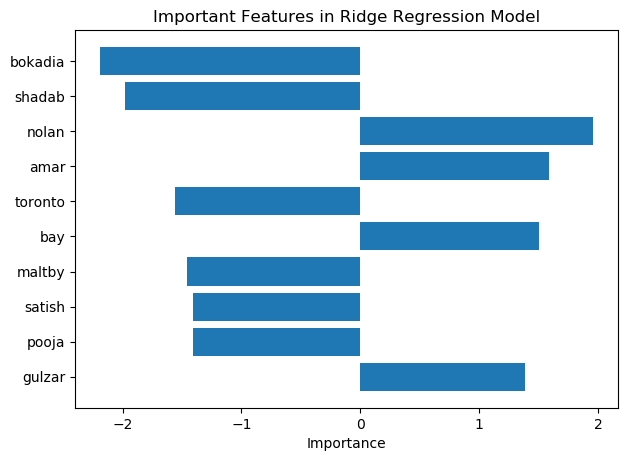

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(largest_weights))

ax.barh(y_pos, reg.coef_[largest_weights], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(column_names[largest_weights])
ax.invert_yaxis()  
ax.set_xlabel('Importance')
ax.set_title('Important Features in Ridge Regression Model')

plt.show()

In [27]:
from sklearn import tree

from sklearn.tree import DecisionTreeRegressor

In [46]:
d_tree = DecisionTreeRegressor(max_depth=4, random_state= seed_number).fit(X_train, y_train)
y_pred = d_tree.predict(X_test)

In [47]:
print(reg.score(X_train, y_train), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred))

0.6672161022605263 1.5647856820292578 0.9900269375529772


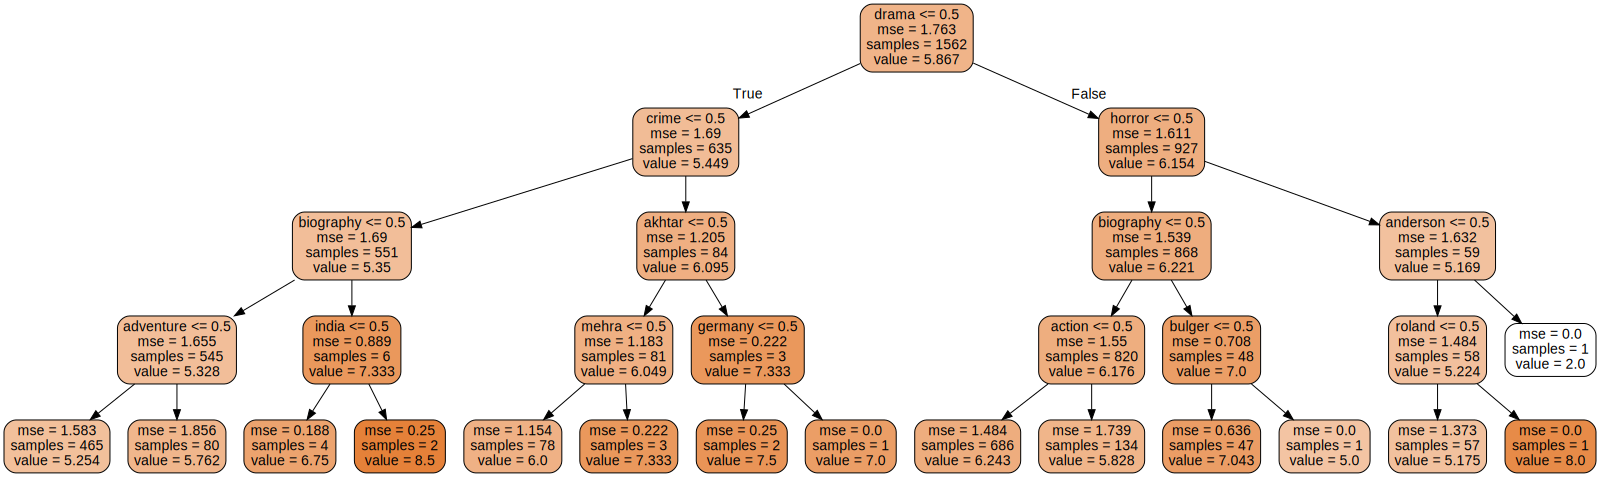

In [48]:
import graphviz 

dot_data = tree.export_graphviz(d_tree, out_file=None, 
                                feature_names=column_names,  filled=True, rounded=True) 
graph = graphviz.Source(dot_data)

graph

## Hyperparameter Optimization

## GridSearch

### Linear Model

In [91]:
param_lr = {'alpha': np.linspace(0, 1, 10),
                 'normalize': [True, False],
                 'solver': ['auto', 'cholesky', 'sparse_cg']
                }

score = 'neg_mean_absolute_error'

ridge = GridSearchCV(Ridge(random_state=seed_number), param_grid=param_lr, scoring=score)
ridge.fit(X_train, y_train)

/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ]), 'normalize': [True, False], 'solver': ['auto', 'cholesky', 'sparse_cg']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [51]:
print('Best parameterse for score {}: {}'.format(s, ridge.best_params_)) 

Best parameterse for score neg_mean_squared_error: {'alpha': 1.0, 'normalize': True, 'solver': 'sparse_cg'}


In [52]:
y_pred = ridge.predict(X_test)

In [53]:
print(ridge.score(X_train, y_train), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred))

-0.5980959616307482 1.5970785983386393 0.993548759498827


#### Decision Tree

In [88]:
param_dt = {"max_depth": np.arange(2, 20), 
             'splitter': ['best', 'random'],
              'min_samples_split': np.arange(2, 5)}

In [89]:
score = 'neg_mean_absolute_error'

dt_tree_reg = GridSearchCV(DecisionTreeRegressor(random_state=seed_number), param_grid=param_dt, scoring=score)
dt_tree_reg.fit(X_train, y_train)
print('Best parameterse for score {}: {}'.format(s, dt_tree_reg.best_params_))

/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameterse for score neg_mean_squared_error: {'max_depth': 3, 'min_samples_split': 2, 'splitter': 'random'}


In [76]:
y_pred_dt = dt_tree_reg.predict(X_test)

In [77]:
print(dt_tree_reg.score(X_train, y_train), mean_squared_error(y_test, y_pred_dt), mean_absolute_error(y_test, y_pred_dt))

-1.0083483358322363 1.5786510889315089 1.0067933917792493


### Random Search

### Linear Model

In [92]:
# run randomized search
n_iter_search = 20
random_lr = RandomizedSearchCV(Ridge(random_state=seed_number), param_distributions=param_lr,
                                   n_iter=n_iter_search)

random_lr.fit(X_train, y_train)
print('Best parameterse for score {}: {}'.format(s, random_dtree.best_params_))

/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameterse for score neg_mean_squared_error: {'splitter': 'random', 'min_samples_split': 4, 'max_depth': 3}


In [93]:
y_pred_r_lreg = random_lr.predict(X_test)

In [95]:
print(random_lr.score(X_train, y_train), mean_squared_error(y_test, y_pred_r_lreg), mean_absolute_error(y_test, y_pred_r_lreg))

0.6190711641607636 1.5970785983386393 0.993548759498827


### Decision Tree

In [90]:
# run randomized search
n_iter_search = 20
random_dtree = RandomizedSearchCV(DecisionTreeRegressor(random_state=seed_number), param_distributions=param_dt,
                                   n_iter=n_iter_search)

random_dtree.fit(X_train, y_train)
print('Best parameterse for score {}: {}'.format(s, random_dtree.best_params_))

/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameterse for score neg_mean_squared_error: {'splitter': 'random', 'min_samples_split': 4, 'max_depth': 3}


In [99]:
y_pred_dt_random = random_dtree.predict(X_test)

In [100]:
print(random_dtree.score(X_train, y_train), mean_squared_error(y_test, y_pred_dt_random), mean_absolute_error(y_test, y_pred_dt_random))

0.13028835106536085 1.5549752874345513 0.9899790016579753


Let us visually compare the results of both techniques:

In [117]:
lr_grid_score = ridge.score(X_train, y_train)
lr_random_score = random_lr.score(X_train, y_train)

lr_grid_mse =  mean_squared_error(y_test, y_pred)
lr_random_mse = mean_squared_error(y_test, y_pred_r_lreg)

lr_grid_mae = mean_absolute_error(y_test, y_pred)
lr_random_mae = mean_absolute_error(y_test, y_pred_r_lreg)


lr_grid_all_scores = [lr_grid_score, lr_grid_mse, lr_random_mae]
lr_random_all_scores = [lr_random_score, lr_random_mse, lr_random_mae]

In [118]:
dt_grid_score = dt_tree_reg.score(X_train, y_train)
dt_random_score = random_dtree.score(X_train, y_train)

dt_grid_mse =  mean_squared_error(y_test, y_pred_dt)
dt_random_mse = mean_squared_error(y_test, y_pred_dt_random)

dt_grid_mae = mean_absolute_error(y_test, y_pred_dt)
dt_random_mae =  mean_absolute_error(y_test, y_pred_dt_random)

dt_grid_all_scores = [dt_grid_score, dt_grid_mse, dt_grid_mae]
dt_random_all_scores = [dt_random_score, dt_random_mse, dt_random_mae]

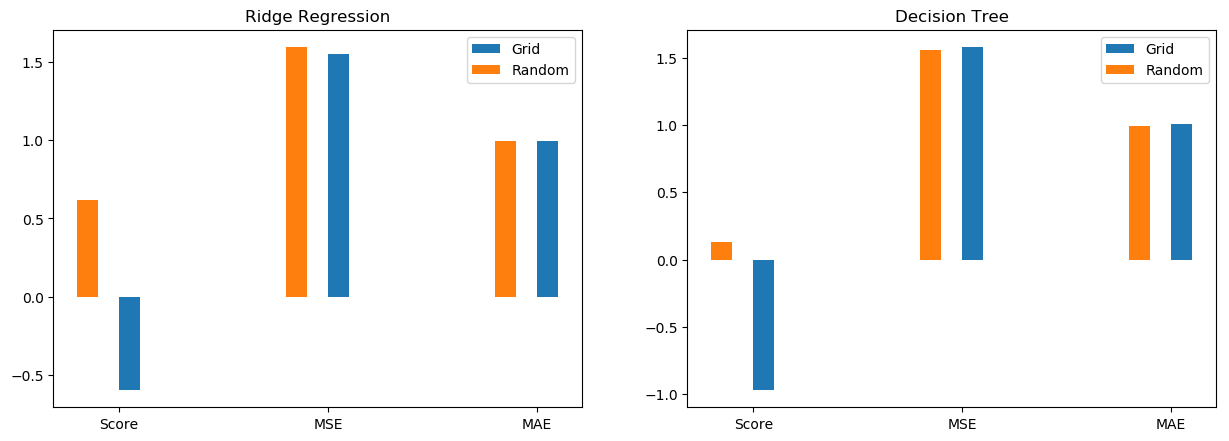

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

N = 3
width = 0.1

ind = np.arange(N)

ax[0].bar(ind + width, lr_grid_all_scores, width, label='Grid')
ax[0].bar(ind - width, lr_random_all_scores, width, label='Random')

ax[0].set_title('Ridge Regression')
ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(('Score', 'MSE', 'MAE'))

ax[0].legend()
ax[0].autoscale_view()


ax[1].bar(ind + width, dt_grid_all_scores, width, label='Grid')
ax[1].bar(ind - width, dt_random_all_scores, width, label='Random')

ax[1].set_title('Decision Tree')
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(('Score', 'MSE', 'MAE'))

ax[1].legend()
ax[1].autoscale_view()


plt.show()